<a href="https://colab.research.google.com/github/usshaa/SkillzRevozCV2/blob/main/OpenCV_Module/notebooks/02_Document_scanner_opencv_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📄 Document Scanner with OpenCV (Colab-Ready)

**Features**
- Upload one images
- Automatic edge detection and 4-point perspective transform
- Adaptive threshold (clean B/W scan look)
- Batch output + optional single PDF export
- Debug views for every step

**How to use**
1. Run each cell in order.
2. Upload image(s) in the *Upload images* cell (JPG/PNG).
3. Scans are saved in `outputs/` and you can optionally save a combined PDF.

> Tip: If your page edges aren’t detected cleanly, tweak the parameters in the **Tuning** cell.


In [18]:
# 🔧 Install dependencies (OpenCV, NumPy, Pillow)
!pip -q install opencv-python-headless numpy pillow

In [19]:
# 📚 Imports
import os, io, glob
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
# ⚙️ Tuning parameters (adjust if detection is poor)
PARAMS = {
    'resize_height': 1000,     # resize working copy by height (preserves aspect)
    'blur_ksize': 5,          # Gaussian blur kernel size (odd)
    'canny_sigma': 0.33,      # auto-canny sigma; lower => more edges
    'dilate_iters': 1,        # edge dilation iterations (0..2)
    'epsilon_pct': 0.02,      # approxPolyDP epsilon fraction of perimeter (0.01..0.05)
    'adaptive_block': 25,     # adaptiveThreshold block size (odd, ~11..41)
    'adaptive_C': 10,         # adaptiveThreshold C (0..15)
}
PARAMS


{'resize_height': 1000,
 'blur_ksize': 5,
 'canny_sigma': 0.33,
 'dilate_iters': 1,
 'epsilon_pct': 0.02,
 'adaptive_block': 25,
 'adaptive_C': 10}

In [21]:
# 🧠 Core utilities: ordering, transform, edge detection, contour selection
def order_points(pts):
    pts = np.array(pts, dtype='float32')
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)
    rect = np.zeros((4, 2), dtype='float32')
    rect[0] = pts[np.argmin(s)]      # top-left
    rect[2] = pts[np.argmax(s)]      # bottom-right
    rect[1] = pts[np.argmin(diff)]   # top-right
    rect[3] = pts[np.argmax(diff)]   # bottom-left
    return rect

In [22]:
def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype='float32')
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [23]:
def auto_canny(image, sigma=0.33):
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

In [24]:
def find_document_contour(edged, epsilon_pct=0.02):
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon_pct * peri, True)
        if len(approx) == 4:
            return approx.reshape(4, 2)
    return None


In [25]:
# 🖨️ Full scanning pipeline
def scan_image(path, params=PARAMS, debug=False):
    original = cv2.imread(path)
    if original is None:
        raise ValueError(f'Could not read image: {path}')
    orig_h, orig_w = original.shape[:2]
    ratio = params['resize_height'] / float(orig_h)
    new_w = int(orig_w * ratio)
    resized = cv2.resize(original, (new_w, params['resize_height']))

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (params['blur_ksize'], params['blur_ksize']), 0)
    edged = auto_canny(gray, sigma=params['canny_sigma'])
    if params['dilate_iters'] > 0:
        kernel = np.ones((3,3), np.uint8)
        edged = cv2.dilate(edged, kernel, iterations=params['dilate_iters'])

    doc_pts = find_document_contour(edged, epsilon_pct=params['epsilon_pct'])

    stages = {'resized': resized, 'gray': gray, 'edged': edged.copy()}

    if doc_pts is None:
        # Fallback: use the whole image as a rectangle
        h, w = resized.shape[:2]
        doc_pts = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32)
        stages['note'] = 'No 4-point contour found; using full image.'

    # Map points back to original scale
    scaled_pts = (doc_pts / ratio).astype('float32')
    warped = four_point_transform(original, scaled_pts)

    # Adaptive threshold for a clean B/W look
    warped_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    T = cv2.adaptiveThreshold(
        warped_gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        max(3, PARAMS['adaptive_block'] | 1),  # ensure odd
        PARAMS['adaptive_C']
    )

    stages.update({'warped': warped, 'scanned': T})
    return T, stages

In [26]:
def show(img, title='image', cmap='gray'):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


In [27]:
# ⬆️ Upload images (JPG/PNG). In Colab, this opens a chooser.
from google.colab import files

# Check if in Colab
try:
  get_ipython().__class__.__name__
  IN_COLAB = True
except:
  IN_COLAB = False

uploaded_paths = []
if IN_COLAB:
    up = files.upload()
    for name, data in up.items():
        with open(name, 'wb') as f:
            f.write(data)
        uploaded_paths.append(name)
else:
    # Not in Colab: put your images in the current directory or specify a folder
    uploaded_paths = sorted(glob.glob('*.jpg') + glob.glob('*.jpeg') + glob.glob('*.png'))

print('Found images:', uploaded_paths)

Saving w17.png to w17.png
Found images: ['w17.png']


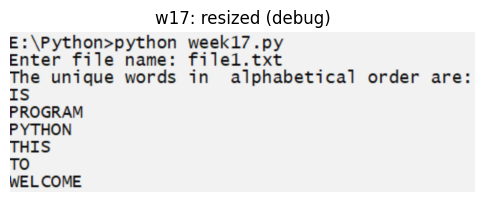

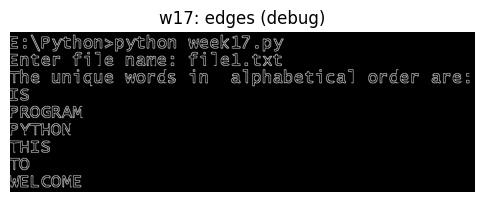

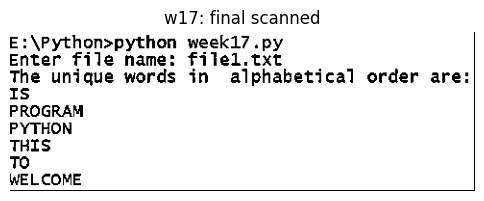

Saved: outputs/w17_scanned.png
All scanned files: ['outputs/w17_scanned.png']


In [28]:
# ▶️ Process all images and save results in outputs/
scanned_files = []
# Create the outputs directory if it doesn't exist
if not os.path.exists('outputs'):
    os.makedirs('outputs')

for p in uploaded_paths:
    try:
        scanned, stages = scan_image(p, debug=True)
        base = os.path.splitext(os.path.basename(p))[0]
        out_path = os.path.join('outputs', f'{base}_scanned.png')
        cv2.imwrite(out_path, scanned)
        scanned_files.append(out_path)
        # Quick preview
        show(stages['resized'], f'{base}: resized (debug)')
        show(stages['edged'], f'{base}: edges (debug)')
        show(scanned, f'{base}: final scanned')
        print('Saved:', out_path)
    except Exception as e:
        print('Error processing', p, e)

if not scanned_files:
    print('No outputs produced. Try adjusting parameters in the Tuning cell.')
else:
    print('All scanned files:', scanned_files)

In [29]:
# 🧾 (Optional) Combine all scans into a single PDF
pdf_path = 'outputs/scans_combined.pdf'
images = []
# Initialize scanned_files in case the previous cell was skipped
scanned_files = scanned_files if 'scanned_files' in locals() else []

for f in scanned_files:
    im = Image.open(f)
    if im.mode != 'RGB':
        im = im.convert('RGB')
    images.append(im)

if images:
    first, rest = images[0], images[1:]
    first.save(pdf_path, save_all=True, append_images=rest)
    print('Saved PDF:', pdf_path)
else:
    print('No scanned images to combine. Run the processing cell first.')

Saved PDF: outputs/scans_combined.pdf


## Troubleshooting
- If no 4-point contour is found, the script falls back to using the full image.
- Increase `dilate_iters` and decrease `epsilon_pct` if edges are broken.
- Try different `adaptive_block` (odd numbers) and `adaptive_C` for better B/W quality.
